# Laboratory Work 3: Exploring CNN Architectures


### Objective:
- Implement two well-known CNN architectures from scratch for classification using the MNIST dataset.
- Compare their performance with the LeNet-5 model from Lab 2.


In [2]:

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
    

In [3]:

# Data loading and preprocessing (MNIST dataset)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and prepare datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Split train dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100.0%

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### VGG-like Architecture Implementation

In [4]:

# Define a VGG-like CNN architecture
class VGGNet(nn.Module):
    def __init__(self, num_classes=10):
        super(VGGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize the model, loss function, and optimizer
vgg_model = VGGNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)
    

In [5]:

# Training loop for VGGNet
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=5):
    train_loss, val_loss = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        # Validation step
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
        val_loss.append(val_running_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}")
    return train_loss, val_loss

# Train VGGNet
vgg_train_loss, vgg_val_loss = train_model(vgg_model, criterion, optimizer, train_loader, val_loader, num_epochs=5)
    

Epoch 1/5, Train Loss: 0.1551, Val Loss: 0.0471
Epoch 2/5, Train Loss: 0.0481, Val Loss: 0.0649
Epoch 3/5, Train Loss: 0.0322, Val Loss: 0.0338
Epoch 4/5, Train Loss: 0.0262, Val Loss: 0.0319
Epoch 5/5, Train Loss: 0.0190, Val Loss: 0.0340


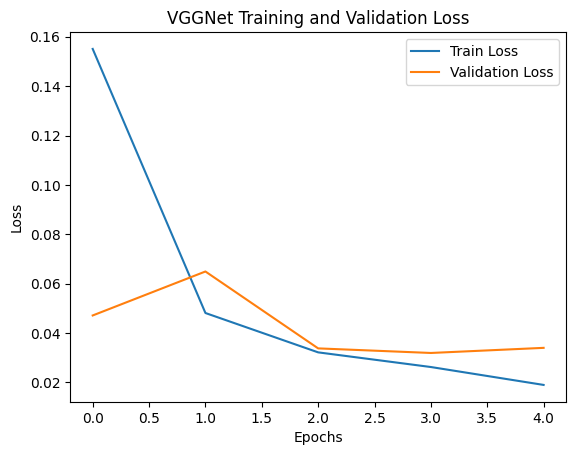

In [6]:

# Plot training and validation loss
plt.plot(vgg_train_loss, label='Train Loss')
plt.plot(vgg_val_loss, label='Validation Loss')
plt.title('VGGNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    

### ResNet Implementation

In [8]:

import torch.nn.functional as F  # Додано імпорт модуля torch.nn.functional

# Define a simple ResNet-like architecture
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        self.layer1 = BasicBlock(1, 64, stride=2)
        self.layer2 = BasicBlock(64, 128, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize the ResNet model, loss function, and optimizer
resnet_model = ResNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)

# Train ResNet
resnet_train_loss, resnet_val_loss = train_model(resnet_model, criterion, optimizer, train_loader, val_loader, num_epochs=5)

Epoch 1/5, Train Loss: 0.2582, Val Loss: 0.0869
Epoch 2/5, Train Loss: 0.0602, Val Loss: 0.0537
Epoch 3/5, Train Loss: 0.0412, Val Loss: 0.0843
Epoch 4/5, Train Loss: 0.0306, Val Loss: 0.0568
Epoch 5/5, Train Loss: 0.0230, Val Loss: 0.0540


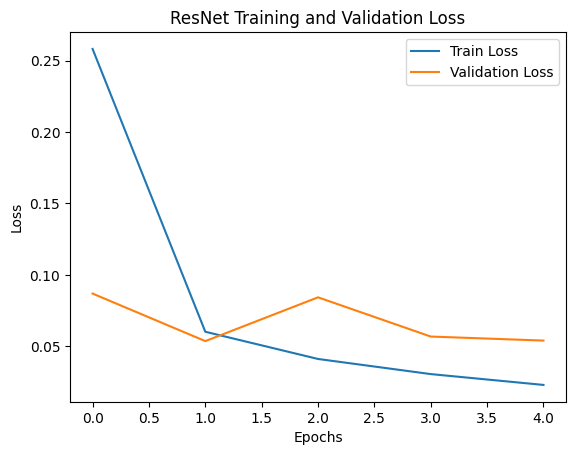

In [9]:

# Plot training and validation loss for ResNet
plt.plot(resnet_train_loss, label='Train Loss')
plt.plot(resnet_val_loss, label='Validation Loss')
plt.title('ResNet Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
    